In [1]:
import os, glob, pandas as pd, numpy as np
from sklearn.model_selection import GroupShuffleSplit
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns

ROOT = "../data"
print("CSV files:", glob.glob(os.path.join(ROOT, "csv", "*.csv")))


2025-10-18 22:11:16.245269: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-18 22:11:16.280113: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-18 22:11:16.280173: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-18 22:11:16.281551: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-18 22:11:16.289177: I tensorflow/core/platform/cpu_feature_guar

CSV files: ['../data/csv/calc_case_description_test_set.csv', '../data/csv/calc_case_description_train_set.csv', '../data/csv/dicom_info.csv', '../data/csv/mass_case_description_test_set.csv', '../data/csv/mass_case_description_train_set.csv', '../data/csv/meta.csv']


In [2]:
mass_train = pd.read_csv(f"{ROOT}/csv/mass_case_description_train_set.csv")
mass_train.head()


,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....


Number of samples: 1318

Columns:
 Index(['patient_id', 'breast_density', 'left or right breast', 'image view',
       'abnormality id', 'abnormality type', 'mass shape', 'mass margins',
       'assessment', 'pathology', 'subtlety', 'image file path',
       'cropped image file path', 'ROI mask file path'],
      dtype='object')

Unique pathologies: ['MALIGNANT' 'BENIGN' 'BENIGN_WITHOUT_CALLBACK']


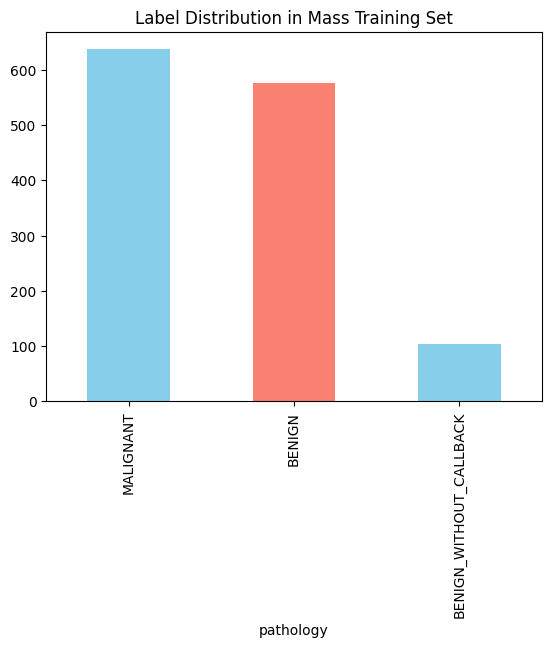

In [3]:
print("Number of samples:", len(mass_train))
print("\nColumns:\n", mass_train.columns)
print("\nUnique pathologies:", mass_train['pathology'].unique())

# Count of each label
mass_train['pathology'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Label Distribution in Mass Training Set')
plt.show()


Total samples: 3568


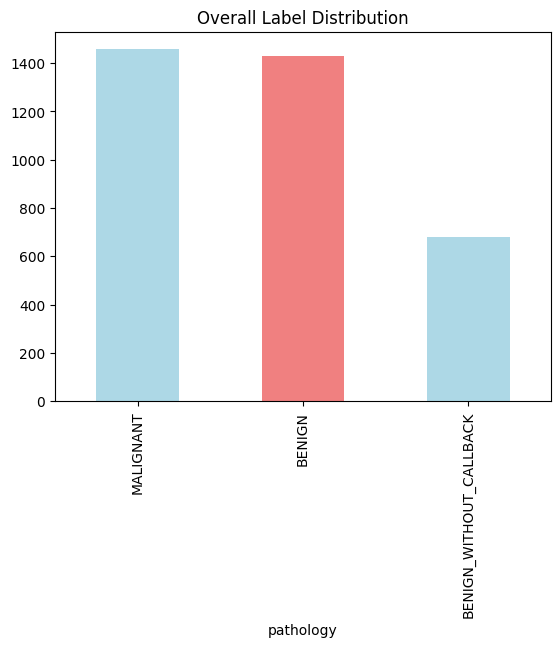

type  pathology              
calc  MALIGNANT                  673
      BENIGN                     658
      BENIGN_WITHOUT_CALLBACK    541
mass  MALIGNANT                  784
      BENIGN                     771
      BENIGN_WITHOUT_CALLBACK    141
Name: count, dtype: int64


In [4]:
mass = pd.concat([
    pd.read_csv(f"{ROOT}/csv/mass_case_description_train_set.csv"),
    pd.read_csv(f"{ROOT}/csv/mass_case_description_test_set.csv")
])
calc = pd.concat([
    pd.read_csv(f"{ROOT}/csv/calc_case_description_train_set.csv"),
    pd.read_csv(f"{ROOT}/csv/calc_case_description_test_set.csv")
])

mass['type'] = 'mass'
calc['type'] = 'calc'
df = pd.concat([mass, calc])

print("Total samples:", len(df))
df['pathology'].value_counts().plot(kind='bar', color=['lightblue', 'lightcoral'])
plt.title('Overall Label Distribution')
plt.show()

print(df.groupby('type')['pathology'].value_counts())


In [5]:
import os
print(os.listdir("../data")[:10])

# Helper function
def replace_path(series, old_path="CBIS-DDSM", new_path="../data"):
    return series.str.replace(old_path, new_path, regex=True).str.replace(".dcm", ".jpg")

# Apply this to your dataframe
df['cropped_image_fixed'] = replace_path(df['cropped image file path'])


['csv', 'jpeg']


In [6]:
print(df['cropped_image_fixed'].iloc[0])


Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.108268213011361124203859148071588939106/1.3.6.1.4.1.9590.100.1.2.296736403313792599626368780122205399650/000000.jpg


In [7]:
import glob, os

# collect every .jpg file path
jpeg_paths = glob.glob(f"{ROOT}/jpeg/**/*jpg", recursive=True)

# map the DICOM-ID (the long number) → real .jpg path
jpeg_map = {}
for p in jpeg_paths:
    key = p.split('/')[3]           # the 6th element is the DICOM-ID
    jpeg_map[key] = p

print("Total JPEGs found:", len(jpeg_map))
# preview one mapping
list(jpeg_map.items())[:3]


Total JPEGs found: 6774


[('1.3.6.1.4.1.9590.100.1.2.100018879311824535125115145152454291132',
  '../data/jpeg/1.3.6.1.4.1.9590.100.1.2.100018879311824535125115145152454291132/2-241.jpg'),
 ('1.3.6.1.4.1.9590.100.1.2.100131208110604806117271735422083351547',
  '../data/jpeg/1.3.6.1.4.1.9590.100.1.2.100131208110604806117271735422083351547/1-126.jpg'),
 ('1.3.6.1.4.1.9590.100.1.2.100522099512256189513864912954167862869',
  '../data/jpeg/1.3.6.1.4.1.9590.100.1.2.100522099512256189513864912954167862869/1-231.jpg')]

In [8]:
def fix_cropped_path(old_path):
    """
    Convert broken DICOM paths to real .jpg paths in /jpeg folder.
    Returns None if not found.
    """
    try:
        key = old_path.split('/')[2]   # extract the DICOM-ID part
        return jpeg_map.get(key, None)
    except Exception:
        return None

df['cropped_image_fixed'] = df['cropped image file path'].apply(fix_cropped_path)

# check how many got fixed
print("Fixed paths:", df['cropped_image_fixed'].notna().sum())
print("Missing paths:", df['cropped_image_fixed'].isna().sum())
print("Example path:\n", df['cropped_image_fixed'].dropna().iloc[0])


Fixed paths: 3567
Missing paths: 1
Example path:
 ../data/jpeg/1.3.6.1.4.1.9590.100.1.2.296736403313792599626368780122205399650/2-249.jpg


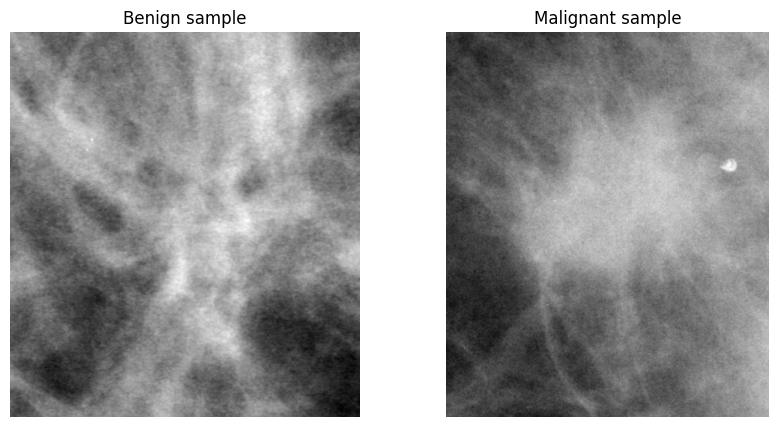

In [9]:
import cv2, matplotlib.pyplot as plt

def show_image(image_path, title=""):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("⚠️ Could not load image:", image_path)
        return
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')

benign = df[df['pathology'].str.contains('BENIGN', case=False)].iloc[0]
malig  = df[df['pathology'].str.contains('MALIG',  case=False)].iloc[0]

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
show_image(benign['cropped_image_fixed'], "Benign sample")
plt.subplot(1,2,2)
show_image(malig['cropped_image_fixed'], "Malignant sample")
plt.show()


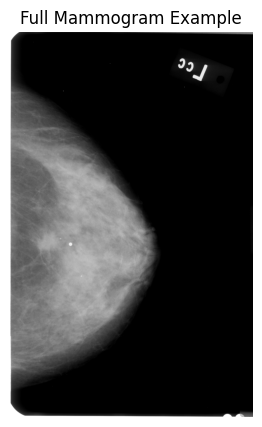

In [10]:
def fix_full_path(old_path):
    try:
        key = old_path.split('/')[2]
        return jpeg_map.get(key, None)
    except Exception:
        return None

df['full_image_fixed'] = df['image file path'].apply(fix_full_path)
plt.figure(figsize=(10,5))
show_image(df['full_image_fixed'].dropna().iloc[0], "Full Mammogram Example")


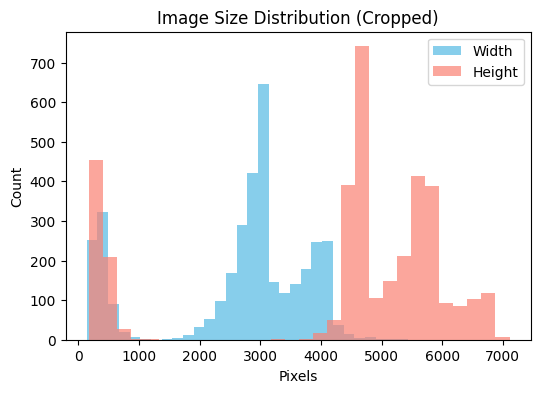

In [11]:
#Check image size distribution
import cv2

def get_size(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return (None, None)
    return img.shape[:2]  # (height, width)

sizes = df['cropped_image_fixed'].dropna().apply(get_size)
heights, widths = zip(*sizes)

plt.figure(figsize=(6,4))
plt.hist(widths, bins=30, color='skyblue', label='Width')
plt.hist(heights, bins=30, color='salmon', alpha=0.7, label='Height')
plt.xlabel("Pixels")
plt.ylabel("Count")
plt.legend()
plt.title("Image Size Distribution (Cropped)")
plt.show()


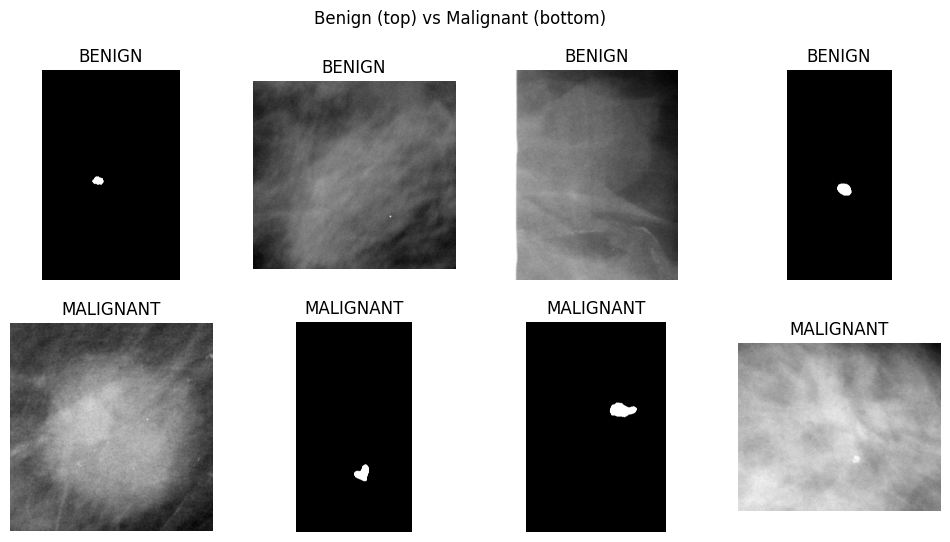

In [12]:
#Show a small grid of benign vs malignant examples:
import random

plt.figure(figsize=(12,6))
benigns = df[df['pathology'].str.contains('BENIGN', case=False)].sample(4, random_state=1)
maligs  = df[df['pathology'].str.contains('MALIG',  case=False)].sample(4, random_state=2)

for i, row in enumerate(pd.concat([benigns, maligs]).itertuples()):
    plt.subplot(2,4,i+1)
    show_image(row.cropped_image_fixed, row.pathology)
plt.suptitle("Benign (top) vs Malignant (bottom)")
plt.show()


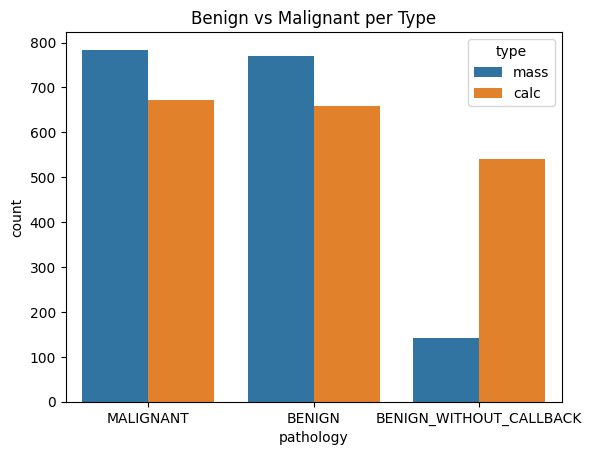

In [13]:
#mass vs calcification
sns.countplot(x='pathology', hue='type', data=df)
plt.title("Benign vs Malignant per Type")
plt.show()


In [14]:
df['label'] = df['pathology'].apply(lambda x: 1 if 'MALIGNANT' in x else 0)
#It converts your 3 pathology labels into a single binary target:
#1 → Malignant (cancer)
#0 → Benign (no cancer)

In [15]:
missing = df[df['cropped_image_fixed'].isna()]
print("❌ Missing image paths:", len(missing))
print(missing[['pathology', 'cropped image file path']].head())


❌ Missing image paths: 1
                    pathology  \
1216  BENIGN_WITHOUT_CALLBACK   

                                cropped image file path  
1216  Calc-Training_P_01563_RIGHT_MLO_2/1.3.6.1.4.1....  


In [16]:
df = df[df['cropped_image_fixed'].notna()].reset_index(drop=True)
print("✅ Remaining valid samples:", len(df))

✅ Remaining valid samples: 3567


In [17]:
# Check label balance
print(df['pathology'].value_counts())
print(df['label'].value_counts())

# Check for wrong/missing images
bad = df[~df['cropped_image_fixed'].apply(lambda x: os.path.exists(x))]
print("Missing files:", len(bad))


pathology
MALIGNANT                  1457
BENIGN                     1429
BENIGN_WITHOUT_CALLBACK     681
Name: count, dtype: int64
label
0    2110
1    1457
Name: count, dtype: int64
Missing files: 0


In [18]:
#train/validation split
from sklearn.model_selection import GroupShuffleSplit

# Use patient_id to avoid leakage
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(gss.split(df, groups=df["patient_id"]))

train_df = df.iloc[train_idx].reset_index(drop=True)
val_df = df.iloc[val_idx].reset_index(drop=True)

print("Train samples:", len(train_df))
print("Validation samples:", len(val_df))
print("Malignant ratio in train:", train_df['label'].mean())
print("Malignant ratio in val:", val_df['label'].mean())


Train samples: 2873
Validation samples: 694
Malignant ratio in train: 0.4152453880960668
Malignant ratio in val: 0.3804034582132565


In [19]:
import tensorflow as tf

IMG_SIZE = 512   # standard for mammograms (you can try 256 if GPU is small)
BATCH_SIZE = 8
AUTO = tf.data.AUTOTUNE

# Load and preprocess a single image
def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=1)       # grayscale
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.image.convert_image_dtype(img, tf.float32)  # scale to [0,1]
    return img, tf.cast(label, tf.float32)

# Simple augmentation (horizontal flip, brightness, contrast)
def augment(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, 0.05)
    img = tf.image.random_contrast(img, 0.9, 1.1)
    return img, label

In [20]:
def make_dataset(dataframe, training=True):
    ds = tf.data.Dataset.from_tensor_slices((dataframe['cropped_image_fixed'], dataframe['label']))
    ds = ds.map(load_image, num_parallel_calls=AUTO)
    if training:
        ds = ds.map(augment, num_parallel_calls=AUTO)
        ds = ds.shuffle(512, reshuffle_each_iteration=True)
    return ds.batch(BATCH_SIZE).prefetch(AUTO)

train_ds = make_dataset(train_df, training=True)
val_ds   = make_dataset(val_df, training=False)


2025-10-18 22:11:53.396505: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [21]:
for images, labels in train_ds.take(1):
    print("✅ batch shape:", images.shape, labels.numpy())

✅ batch shape: (8, 512, 512, 1) [0. 1. 0. 1. 1. 1. 1. 0.]


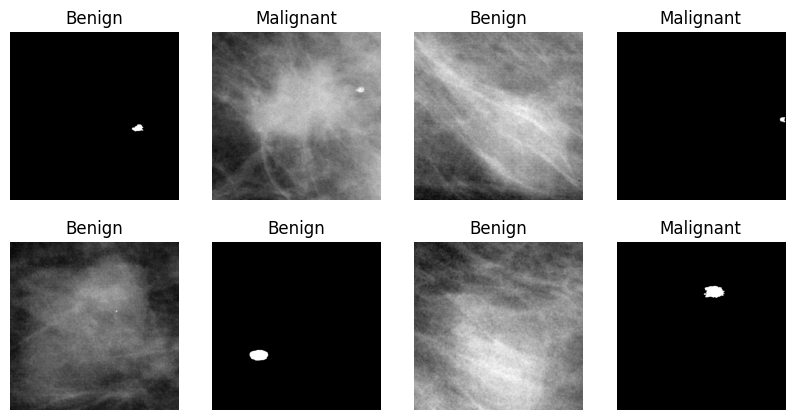

In [22]:
import matplotlib.pyplot as plt

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10,5))
    for i in range(8):
        plt.subplot(2,4,i+1)
        plt.imshow(tf.squeeze(images[i]), cmap='gray')
        plt.title("Malignant" if labels[i]==1 else "Benign")
        plt.axis('off')
    plt.show()


In [23]:
from tensorflow.keras import layers, models

def build_cnn(input_shape=(512, 512, 1)):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(256, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(1, activation='sigmoid')  # binary classification
    ])
    return model

cnn = build_cnn()
cnn.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 510, 510, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 255, 255, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 253, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 126, 126, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 128)     73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 62, 62, 128)       0

_________________________________________________________________


In [24]:
cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)


In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(os.path.join(MODEL_DIR, "best_cnn.keras"), save_best_only=True, monitor='val_auc', mode='max'),
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_auc', mode='max', restore_best_weights=True)
]

history = cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=callbacks
)


Epoch 1/15


360/360 [==============================] - 82s 223ms/step - loss: 1.6205 - accuracy: 0.5687 - auc: 0.5542 - val_loss: 0.6548 - val_accuracy: 0.6311 - val_auc: 0.5943
Epoch 2/15
360/360 [==============================] - 80s 220ms/step - loss: 0.6408 - accuracy: 0.6307 - auc: 0.6601 - val_loss: 0.6673 - val_accuracy: 0.6354 - val_auc: 0.5892
Epoch 3/15
360/360 [==============================] - 81s 223ms/step - loss: 0.5972 - accuracy: 0.6784 - auc: 0.7252 - val_loss: 0.6860 - val_accuracy: 0.6196 - val_auc: 0.5786
Epoch 4/15
360/360 [==============================] - 82s 228ms/step - loss: 0.5551 - accuracy: 0.6965 - auc: 0.7697 - val_loss: 0.7215 - val_accuracy: 0.6167 - val_auc: 0.5811
Epoch 5/15
360/360 [==============================] - 81s 224ms/step - loss: 0.5312 - accuracy: 0.7334 - auc: 0.8076 - val_loss: 0.7129 - val_accuracy: 0.5922 - val_auc: 0.5733
Epoch 6/15
360/360 [==============================] - 81s 224ms/step - loss: 0.4753 - accuracy: 0.7584 - auc: 0.8479 - val_los

In [ ]:
import os

# Create model directory if it doesn't exist
MODEL_DIR = "../models"
os.makedirs(MODEL_DIR, exist_ok=True)
print(f"Models will be saved to: {MODEL_DIR}")

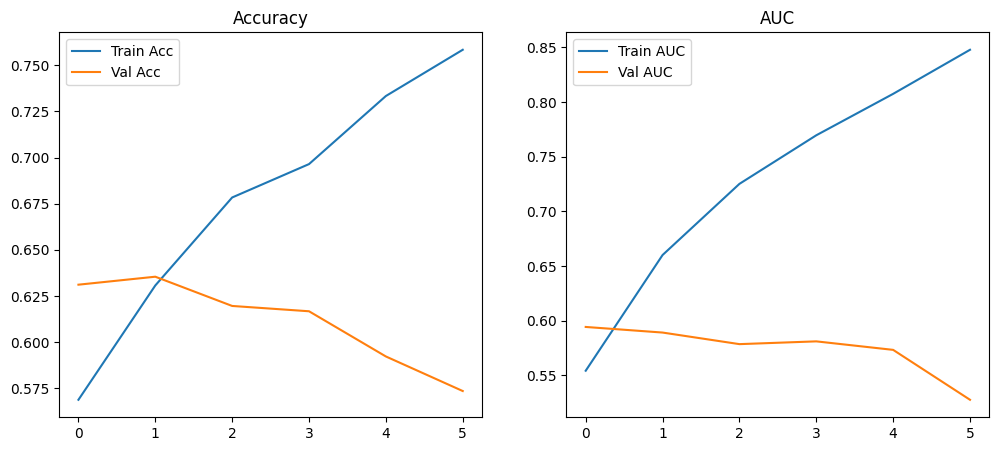

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.title('AUC')
plt.legend()
plt.show()


In [27]:
cnn.evaluate(val_ds)


87/87 [==============================] - 8s 86ms/step - loss: 0.6548 - accuracy: 0.6311 - auc: 0.5943


[0.6548165678977966, 0.6311239004135132, 0.5943005681037903]

In [28]:
import numpy as np
from sklearn.metrics import confusion_matrix, roc_auc_score

y_true, y_pred = [], []
for imgs, labels in val_ds:
    preds = cnn.predict(imgs)
    y_pred.extend(preds.ravel())
    y_true.extend(labels.numpy())

y_pred_bin = np.array(y_pred) > 0.5
print("AUC:", roc_auc_score(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred_bin))


1/1 [==============================] - 0s 86ms/step
AUC: 0.5952915785764623
Confusion Matrix:
 [[401  29]
 [227  37]]


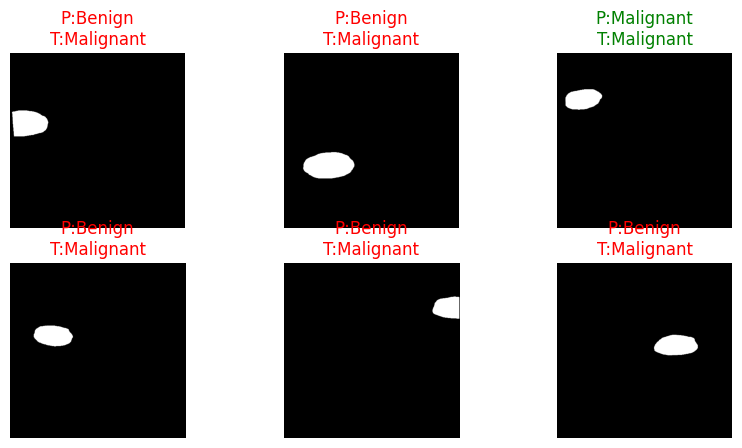

In [29]:
plt.figure(figsize=(10,5))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(tf.squeeze(imgs[i]), cmap='gray')
    pred = "Malignant" if y_pred_bin[i] else "Benign"
    true = "Malignant" if labels[i]==1 else "Benign"
    color = "red" if pred != true else "green"
    plt.title(f"P:{pred}\nT:{true}", color=color)
    plt.axis('off')
plt.show()


In [30]:
def to_rgb(img, label):
    img = tf.image.grayscale_to_rgb(img)
    return img, label

train_rgb = train_ds.map(to_rgb)
val_rgb = val_ds.map(to_rgb)


In [31]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models

base = EfficientNetB0(
    include_top=False,
    input_shape=(512, 512, 3),
    weights="imagenet"
)

# freeze base initially
base.trainable = False

inputs = layers.Input((512, 512, 3))
x = base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = models.Model(inputs, outputs)


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(os.path.join(MODEL_DIR, "best_efficientnet.keras"),
                                       save_best_only=True,
                                       monitor="val_auc",
                                       mode="max"),
    tf.keras.callbacks.EarlyStopping(patience=4,
                                     monitor="val_auc",
                                     mode="max",
                                     restore_best_weights=True)
]

history = model.fit(
    train_rgb,
    validation_data=val_rgb,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
360/360 [==============================] - 123s 333ms/step - loss: 0.6734 - accuracy: 0.5830 - auc: 0.5673 - val_loss: 0.6484 - val_accuracy: 0.6311 - val_auc: 0.6490
Epoch 2/10
360/360 [==============================] - 119s 329ms/step - loss: 0.6587 - accuracy: 0.6070 - auc: 0.6205 - val_loss: 0.6341 - val_accuracy: 0.6369 - val_auc: 0.6735
Epoch 3/10
360/360 [==============================] - 119s 330ms/step - loss: 0.6499 - accuracy: 0.6164 - auc: 0.6457 - val_loss: 0.6257 - val_accuracy: 0.6470 - val_auc: 0.6851
Epoch 4/10
360/360 [==============================] - 119s 330ms/step - loss: 0.6417 - accuracy: 0.6258 - auc: 0.6600 - val_loss: 0.6211 - val_accuracy: 0.6657 - val_auc: 0.6891
Epoch 5/10
360/360 [==============================] - 119s 328ms/step - loss: 0.6368 - accuracy: 0.6366 - auc: 0.6693 - val_loss: 0.6150 - val_accuracy: 0.6700 - val_auc: 0.6901
Epoch 6/10
360/360 [==============================] - 119s 329ms/step - loss: 0.6321 - accuracy: 0.6391 - auc:

In [33]:
print("Final training accuracy:", history.history['accuracy'][-1])
print("Final validation accuracy:", history.history['val_accuracy'][-1])
print("Final training AUC:", history.history['auc'][-1])
print("Final validation AUC:", history.history['val_auc'][-1])


Final training accuracy: 0.6526278853416443
Final validation accuracy: 0.6844380497932434
Final training AUC: 0.6901748776435852
Final validation AUC: 0.6978594064712524


In [34]:
results = model.evaluate(val_rgb)
print(f"Loss: {results[0]:.4f}")
print(f"Accuracy: {results[1]:.4f}")
print(f"AUC: {results[2]:.4f}")


87/87 [==============================] - 23s 265ms/step - loss: 0.6027 - accuracy: 0.6844 - auc: 0.6979
Loss: 0.6027
Accuracy: 0.6844
AUC: 0.6979


In [35]:
# Unfreeze base model
base.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # smaller LR for fine-tuning
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

history_ft = model.fit(
    train_rgb,
    validation_data=val_rgb,
    epochs=5,
    callbacks=callbacks
)


Epoch 1/5


360/360 [==============================] - 296s 794ms/step - loss: 0.6170 - accuracy: 0.6523 - auc: 0.6973 - val_loss: 0.6055 - val_accuracy: 0.6671 - val_auc: 0.7050
Epoch 2/5
360/360 [==============================] - 285s 791ms/step - loss: 0.6060 - accuracy: 0.6697 - auc: 0.7136 - val_loss: 0.5882 - val_accuracy: 0.6931 - val_auc: 0.7285
Epoch 3/5
360/360 [==============================] - 287s 796ms/step - loss: 0.5940 - accuracy: 0.6763 - auc: 0.7300 - val_loss: 0.5940 - val_accuracy: 0.6758 - val_auc: 0.7221
Epoch 4/5
360/360 [==============================] - 287s 796ms/step - loss: 0.5899 - accuracy: 0.6742 - auc: 0.7327 - val_loss: 0.5876 - val_accuracy: 0.6844 - val_auc: 0.7317
Epoch 5/5
360/360 [==============================] - 281s 779ms/step - loss: 0.5855 - accuracy: 0.6753 - auc: 0.7387 - val_loss: 0.5865 - val_accuracy: 0.6873 - val_auc: 0.7287


In [36]:
def augment(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, 0.1)
    img = tf.image.random_contrast(img, 0.8, 1.2)
    img = tf.image.random_rotation(img, 0.1)
    return img, label


In [37]:
print("Final training accuracy:", history_ft.history['accuracy'][-1])
print("Final validation accuracy:", history_ft.history['val_accuracy'][-1])
print("Final training AUC:", history_ft.history['auc'][-1])
print("Final validation AUC:", history_ft.history['val_auc'][-1])


Final training accuracy: 0.675252377986908
Final validation accuracy: 0.6873198747634888
Final training AUC: 0.7386902570724487
Final validation AUC: 0.7287306189537048


In [38]:
df['cropped_image_fixed'] = df['ROI mask file path']


In [39]:
import tensorflow as tf
import numpy as np
import cv2

IMG_SIZE = 512
BATCH_SIZE = 4          # smaller batch for stability
AUTO = tf.data.AUTOTUNE


In [40]:
def clahe_preprocess(path):
    img = cv2.imread(path.decode(), cv2.IMREAD_GRAYSCALE)
    # gentler contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(4,4))
    img = clahe.apply(img)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.astype(np.float32) / 255.0
    return img

def load_image_with_clahe(path, label):
    img = tf.numpy_function(clahe_preprocess, [path], tf.float32)
    img.set_shape((IMG_SIZE, IMG_SIZE, 3))
    return img, tf.cast(label, tf.float32)


In [41]:
def augment(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, 0.05)
    img = tf.image.random_contrast(img, 0.9, 1.1)
    return img, label


In [42]:
def make_dataset(dataframe, training=True):
    ds = tf.data.Dataset.from_tensor_slices((dataframe['cropped_image_fixed'], dataframe['label']))
    ds = ds.map(load_image_with_clahe, num_parallel_calls=AUTO)
    if training:
        ds = ds.map(augment, num_parallel_calls=AUTO)
        ds = ds.shuffle(512, reshuffle_each_iteration=True)
    return ds.batch(BATCH_SIZE).prefetch(AUTO)

train_ds = make_dataset(train_df, training=True)
val_ds   = make_dataset(val_df, training=False)

train_rgb = train_ds
val_rgb = val_ds


In [43]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import layers, models

base = EfficientNetB3(include_top=False, weights="imagenet", input_shape=(IMG_SIZE, IMG_SIZE, 3))
base.trainable = False  # freeze base at first

inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))
x = base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = models.Model(inputs, outputs)


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(os.path.join(MODEL_DIR, "best_b3.keras"), save_best_only=True, monitor="val_auc", mode="max"),
    tf.keras.callbacks.EarlyStopping(patience=4, monitor="val_auc", mode="max", restore_best_weights=True)
]

history = model.fit(train_rgb, validation_data=val_rgb, epochs=8, callbacks=callbacks)


Epoch 1/8
719/719 [==============================] - 354s 482ms/step - loss: 0.6840 - accuracy: 0.5674 - auc: 0.5258 - val_loss: 0.6651 - val_accuracy: 0.6196 - val_auc: 0.4838
Epoch 2/8
719/719 [==============================] - 347s 478ms/step - loss: 0.6865 - accuracy: 0.5684 - auc: 0.5203 - val_loss: 0.6656 - val_accuracy: 0.6196 - val_auc: 0.5025
Epoch 3/8
719/719 [==============================] - 346s 478ms/step - loss: 0.6824 - accuracy: 0.5715 - auc: 0.5316 - val_loss: 0.6643 - val_accuracy: 0.6196 - val_auc: 0.5469
Epoch 4/8
719/719 [==============================] - 346s 477ms/step - loss: 0.6832 - accuracy: 0.5740 - auc: 0.5282 - val_loss: 0.6640 - val_accuracy: 0.6196 - val_auc: 0.5145
Epoch 5/8
719/719 [==============================] - 346s 477ms/step - loss: 0.6846 - accuracy: 0.5701 - auc: 0.5189 - val_loss: 0.6650 - val_accuracy: 0.6196 - val_auc: 0.5238
Epoch 6/8
719/719 [==============================] - 344s 475ms/step - loss: 0.6861 - accuracy: 0.5740 - auc: 0.511

In [45]:
base.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-6),  # smaller learning rate for fine-tuning
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

history_ft = model.fit(train_rgb, validation_data=val_rgb, epochs=8, callbacks=callbacks)


Epoch 1/8
719/719 [==============================] - 727s 983ms/step - loss: 0.6830 - accuracy: 0.5701 - auc: 0.5141 - val_loss: 0.6640 - val_accuracy: 0.6196 - val_auc: 0.5324
Epoch 2/8
719/719 [==============================] - 715s 991ms/step - loss: 0.6817 - accuracy: 0.5816 - auc: 0.5184 - val_loss: 0.6639 - val_accuracy: 0.6196 - val_auc: 0.5891
Epoch 3/8
719/719 [==============================] - 711s 985ms/step - loss: 0.6825 - accuracy: 0.5799 - auc: 0.5145 - val_loss: 0.6644 - val_accuracy: 0.6196 - val_auc: 0.5947
Epoch 4/8
719/719 [==============================] - 712s 986ms/step - loss: 0.6813 - accuracy: 0.5715 - auc: 0.5220 - val_loss: 0.6634 - val_accuracy: 0.6196 - val_auc: 0.5908
Epoch 5/8
719/719 [==============================] - 716s 992ms/step - loss: 0.6831 - accuracy: 0.5767 - auc: 0.5081 - val_loss: 0.6629 - val_accuracy: 0.6196 - val_auc: 0.5852
Epoch 6/8
719/719 [==============================] - 713s 988ms/step - loss: 0.6801 - accuracy: 0.5774 - auc: 0.524

In [46]:
val_loss, val_acc, val_auc = model.evaluate(val_rgb)
print(f"📊 Validation Accuracy: {val_acc:.4f}")
print(f"📈 Validation AUC: {val_auc:.4f}")


174/174 [==============================] - 67s 382ms/step - loss: 0.6341 - accuracy: 0.6628 - auc: 0.6163
📊 Validation Accuracy: 0.6628
📈 Validation AUC: 0.6163


In [ ]:
# List saved models
import os
import glob

saved_models = glob.glob(os.path.join(MODEL_DIR, "*.keras"))
print(f"Saved models in {MODEL_DIR}:")
for model_path in saved_models:
    model_name = os.path.basename(model_path)
    model_size = os.path.getsize(model_path) / (1024 * 1024)  # Convert to MB
    print(f"- {model_name} ({model_size:.2f} MB)")